# Assignment 1: Classifying handwritten digits using probability theory

# 1. Introduce the problem in your own words. You should mention what data we use, what we want to do with it and how we will do it. Explain with your own words the Naive Bayes classifier, it's assumptions and how this can classify the digits $0-9$.

Write your answer here.

The data set cointains images with a black background and drawings of numbers from zero to nine, in white.  The objective is to build a classifier that can correctly distinguish what is the number drawn in the image.  For this, the Naive Bayes classifier will be used. This is an aproximation where each pixel is analysed indpendently of the others.  The advantage of this, is that the number of calclations required is significantly smaller, rather than analysing whole groups of pixels within the image.  To use the Naive Bayes classifier, every pixel is assumed to be independent of each other.  In practice, this may not be the case, but by using the Naive Bayes we only care about a broad degree of accuracy.  

By combining Naive Bayes with a classification rule, we can attempt to implement this.

In [1]:
from __future__ import division
import numpy as np
import pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import plot_confusion_matrix


# 2. Load the data

In [2]:
# load data
data = np.load("mnist_bin.npz") # insert your answer here
## If running into further errors, consult "np.load("mnist_bin.npz",'',allow_pickle=False)"

# get vector representation of binary digits
X = data['X']

# get binary labels
y = data['y']

print('The shape of X is (%d, %d)' % X.shape)
print('The shape of y is (%d)\n' % y.shape)

# Dimensions
N, D = X.shape

print('Number of images: %d' % N)
print('Number of pixels: %d' % D)

The shape of X is (70000, 784)
The shape of y is (70000)

Number of images: 70000
Number of pixels: 784


#### Run the code beneath. It plots 10 images of each digit. 


In [3]:
# Graphical representation function, don't worry about it
def show_image(x, title="", clim=None, cmap=plt.cm.gray, colorbar=False):
    ax = plt.gca()
    im = ax.imshow(x.reshape((28, 28)), cmap=cmap, clim=clim)
    
    if len(title) > 0:
        plt.title(title)
        
    plt.axis('off')
    
    if colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

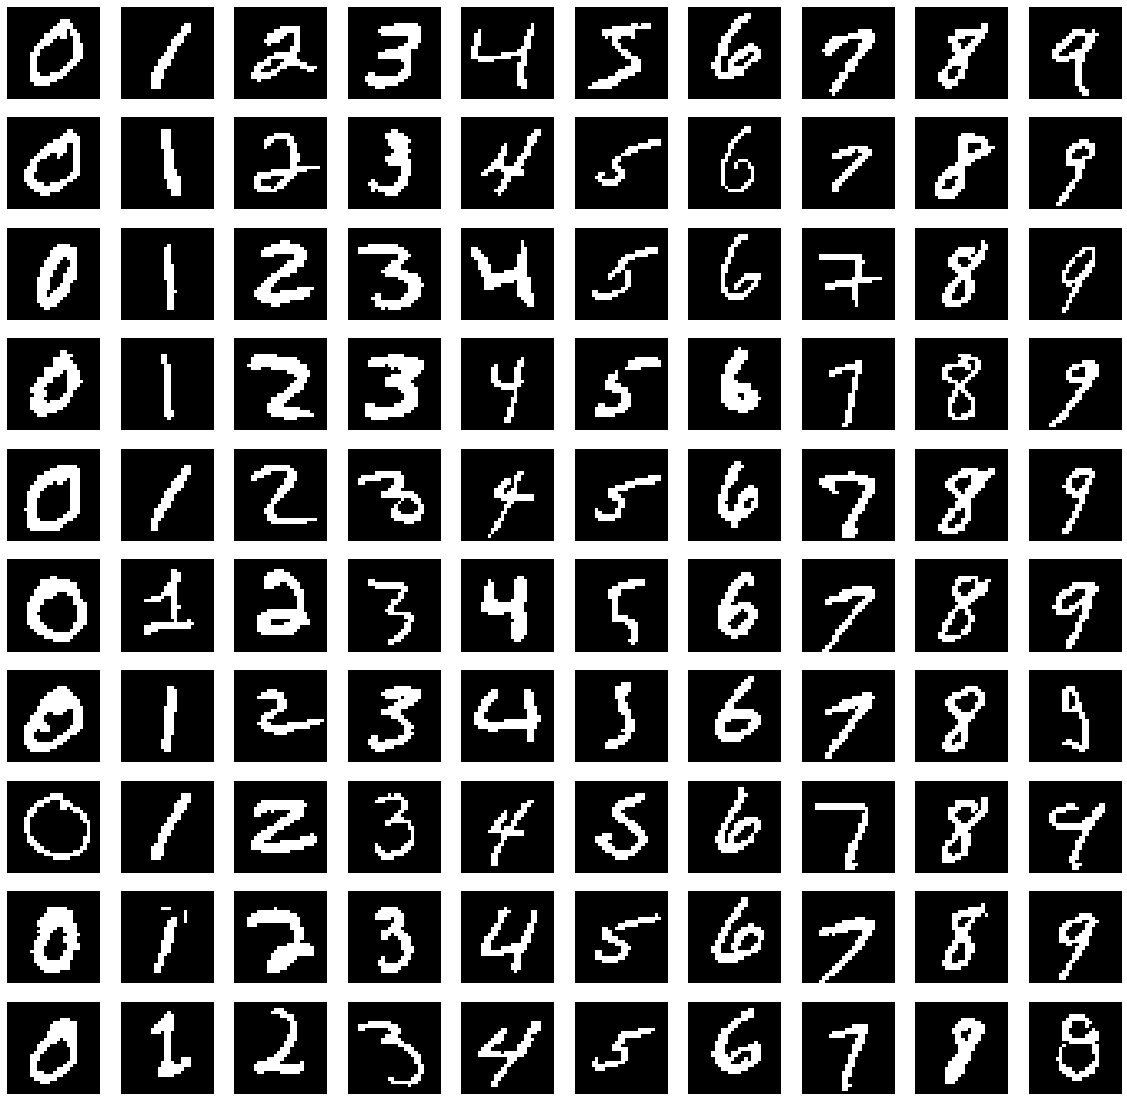

In [4]:
# More graphs

num_images_per_row  = 10
num_labels          = 10

plt.figure(figsize=(20, 20))
counter             = 1
for i in range(num_labels):
    for l in range(num_images_per_row):
        plt.subplot(num_labels, num_images_per_row, counter)

        all_images_belonging_to_class_l = X[y==l,:]
        one_images_belonging_to_class_l = all_images_belonging_to_class_l[i]
        
        show_image(one_images_belonging_to_class_l)  
        counter += 1



# 3. Explain what a training set is, what a test set is and why we as data scientists *always* split data into test/train before doing any modelling. What do we want to avoid?

A training set is a set of data that closely approximates the actual conditions of the sample you wish to study, without infringing on the specific conditions of the elements which you wish to test.  While we could both train and test on the same large set, the results would be suspiciously accurate, as the model would know the precise conditions for the testing set having encountered it in training, and the result would be falsely indicative of the true ability of the classifier.

Therefore, data scientists always split data into test/train and take great care in this, to avoid invalidating their own results with suspiciously high accuracies by leaks between the sets. 

In [5]:
# No reason to change this, particularly.  It's a sensible split between test and train,
# and trying to prune the priors won't solve our problem

N = len(X)
N_train = int(0.8*N)
N_test = N-N_train

# set random seed:
np.random.seed(0) # don't change this :-)

# create a random permutation for splitting into training and test
randperm = np.random.permutation(N)

# split into training and test
train_idx = randperm[:N_train]
test_idx = randperm[N_train:]
Xtrain, Xtest = X[train_idx, :], X[test_idx, :]
ytrain, ytest = y[train_idx], y[test_idx]

print('Total number of images:\t\t%d' % N)
print('Number of training images:\t%d' % N_train)
print('Number of test images:\t\t%d' % N_test)
print(ytrain)

Total number of images:		70000
Number of training images:	56000
Number of test images:		14000
[0 4 1 ... 2 4 6]


# 4. Implement/change the code to handle all digits. 
### Fitting the Naı̈ve-Bayes model to training set: the prior

In [6]:
# count the number of zeros and ones, AND twos, threes, etc.


possible_numbers_vector = np.arange(10)
count_vector= np.arange(10)

for i in count_vector:
    count_vector[i] = np.sum(ytrain == i)

v_priors = count_vector/ N_train #this vector contains the probability of each number to occur

# Prints all the priors, rounded.  Dataset overtrains to 1's, undertrains 5's, but look for 
# the raw vector and see if there's anything under - repped maybe?

# np.set_printoptions(threshold=np.inf) turn on for debugging
print(v_priors)

for i in possible_numbers_vector:
    print('Prior probability (Y = %d)  = %d/%d = %3.2f' % (possible_numbers_vector[i], count_vector[i], N_train, v_priors[i]))



[0.09951786 0.11214286 0.09985714 0.10178571 0.09785714 0.09041071
 0.09833929 0.10317857 0.09730357 0.09960714]
Prior probability (Y = 0)  = 5573/56000 = 0.10
Prior probability (Y = 1)  = 6280/56000 = 0.11
Prior probability (Y = 2)  = 5592/56000 = 0.10
Prior probability (Y = 3)  = 5700/56000 = 0.10
Prior probability (Y = 4)  = 5480/56000 = 0.10
Prior probability (Y = 5)  = 5063/56000 = 0.09
Prior probability (Y = 6)  = 5507/56000 = 0.10
Prior probability (Y = 7)  = 5778/56000 = 0.10
Prior probability (Y = 8)  = 5449/56000 = 0.10
Prior probability (Y = 9)  = 5578/56000 = 0.10


The code beneath is taken from Exercise 1 and it only handles digits 0 and 1. Change the code to handle all digits.

### Fitting the Naı̈ve-Bayes model to training set: the likelihood

In [11]:
### split data base on its label value and put them in a matrix 
# fit model for zeros and ones separately

p_digits = np.zeros((10,784)) 
for k in range(10):
    Xtrain_num = Xtrain[ytrain == k, :]  # all the pictures that contain the label "k".
    p_digits[k] = np.mean(Xtrain[ytrain == k, :], axis=0)

print(p_digits.shape)



(10, 784)


In [12]:
# This code should be sufficient, i.e. don't change this.
def log_likelihood(x_new, p_digit):
    pixel_log_lik = x_new*np.log(p_digit + 1e-16) + (1-x_new)*np.log(1-p_digit)
    return np.sum(pixel_log_lik)
    
image_idxs_to_be_classified = [0,10,510,810]
for image_idx in image_idxs_to_be_classified:
    x_new = Xtrain[image_idx]
    print('Image idx: %d (label=%d)' % (image_idx, ytrain[image_idx]))
    
    for i in range(10):
        print('p(x_new | Y=%d): %3.2e' % (i ,np.exp(log_likelihood(x_new, p_digits[i]))))
    print('\n')

Image idx: 0 (label=0)
p(x_new | Y=0): 1.17e-85
p(x_new | Y=1): 1.53e-243
p(x_new | Y=2): 3.91e-119
p(x_new | Y=3): 5.44e-123
p(x_new | Y=4): 1.82e-118
p(x_new | Y=5): 3.26e-109
p(x_new | Y=6): 6.55e-99
p(x_new | Y=7): 6.98e-188
p(x_new | Y=8): 1.24e-109
p(x_new | Y=9): 1.08e-134


Image idx: 10 (label=1)
p(x_new | Y=0): 3.40e-122
p(x_new | Y=1): 2.94e-34
p(x_new | Y=2): 5.53e-75
p(x_new | Y=3): 1.24e-76
p(x_new | Y=4): 2.29e-86
p(x_new | Y=5): 2.74e-76
p(x_new | Y=6): 1.37e-112
p(x_new | Y=7): 1.06e-83
p(x_new | Y=8): 7.47e-68
p(x_new | Y=9): 6.80e-81


Image idx: 510 (label=1)
p(x_new | Y=0): 2.39e-125
p(x_new | Y=1): 5.00e-34
p(x_new | Y=2): 3.51e-73
p(x_new | Y=3): 1.31e-78
p(x_new | Y=4): 7.04e-96
p(x_new | Y=5): 9.44e-78
p(x_new | Y=6): 3.88e-88
p(x_new | Y=7): 3.38e-107
p(x_new | Y=8): 7.98e-68
p(x_new | Y=9): 6.62e-90


Image idx: 810 (label=6)
p(x_new | Y=0): 6.20e-151
p(x_new | Y=1): 7.56e-150
p(x_new | Y=2): 1.27e-89
p(x_new | Y=3): 2.06e-128
p(x_new | Y=4): 4.94e-108
p(x_ne

### Implementing Bayes's theorem

In [36]:
def compute_posterior_prob(x_new):
    v_liks = np.zeros(10)
    v_terms = np.zeros(10)
    v_posterior = np.zeros(10)
    
    for i in range(10):
        v_liks[i] = np.exp(log_likelihood(x_new, p_digits[i]))
        v_terms[i] = v_liks[i]*v_priors[i]
        
    evidence = np.sum(v_terms)
    
    for i in range(10):
        v_posterior[i] = v_terms[i]/evidence
    
    return v_posterior

def printPosteriors(image_idx):
    print('Image idx: %d (label=%d)' % (image_idx, ytrain[image_idx]))
    x_new = Xtrain[image_idx]
    for i in range(10):
          print('p(Y=%d | x_new): %4.3f' % (i,compute_posterior_prob(x_new)[i])) 

printPosteriors(800)    

Image idx: 800 (label=6)
p(Y=0 | x_new): 0.000
p(Y=1 | x_new): 0.000
p(Y=2 | x_new): 0.000
p(Y=3 | x_new): 0.000
p(Y=4 | x_new): 0.000
p(Y=5 | x_new): 0.000
p(Y=6 | x_new): 1.000
p(Y=7 | x_new): 0.000
p(Y=8 | x_new): 0.000
p(Y=9 | x_new): 0.000


### A simple classification rule: take the class with largest posterior probability

In [39]:
def classify(x):
    posterior = compute_posterior_prob(x)
    predicted_label = np.argmax(posterior)
    return predicted_label
    

### Change this code to classify some images

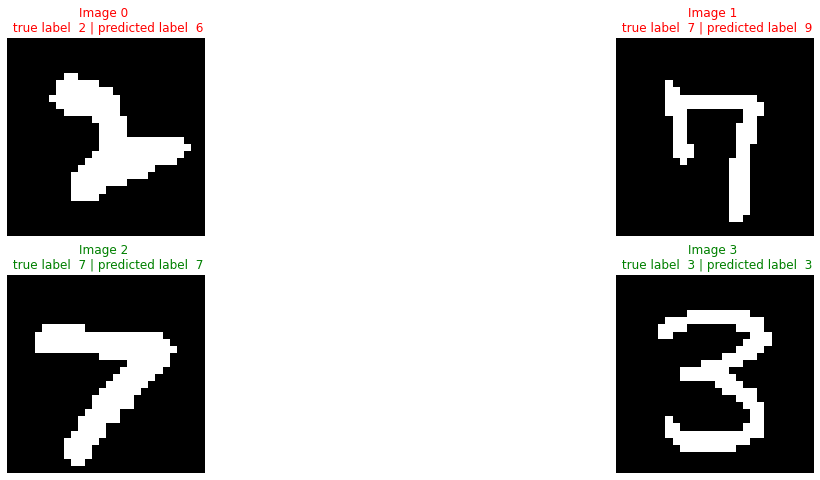

In [49]:
# Classifies the first 10 images in the test set
num_images_per_row = 2
num_rows = 2
num_images = num_images_per_row * num_rows
plt.figure(figsize=(20, 8))
for i in range(num_images):
    plt.subplot(num_rows, num_images_per_row, 1 + i)
    
    # compute posterior probabilities
    v_posterior = compute_posterior_prob(Xtest[i, :])
    
    # get true label and predicted label
    true_label = ytest[i]
    predicted_label = classify(Xtest[i, :])
    # show image 
    show_image(Xtest[i, :])
    # if the classification is correct, use green otherwise use red 

    if true_label == predicted_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.title('Image %d \n true label  %d | predicted label  %d' % (i,true_label,predicted_label), color=color)
    


### Let's compute the training and test errors

In [50]:
ytrain_hat = np.array([classify(x) for x in Xtrain])
ytest_hat = np.array([classify(x) for x in Xtest])

In [51]:
mean_train_acc = np.mean(ytrain_hat == ytrain)
mean_test_acc = np.mean(ytest_hat == ytest)
print('Training accuracy:\t%4.3f' % mean_train_acc)
print('Test accuracy:\t\t%4.3f' % mean_test_acc)

Training accuracy:	0.840
Test accuracy:		0.840


# 5. Compute the confusion matrix and explain what it shows.

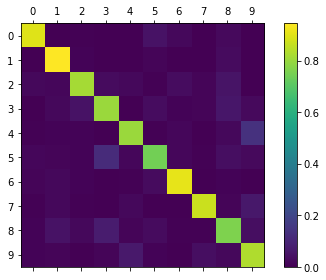

In [52]:
from sklearn.metrics import confusion_matrix
labels = list(range(10))
pred = np.array([classify(x) for x in Xtest])
cm = confusion_matrix(y_true=ytest, y_pred=pred, labels=labels,normalize="true")
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
ax.set_xticks(labels)
ax.set_yticks(labels)
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.tight_layout()
plt.show()

Write your explanation here

# 6. Error analysis: find images that are misclassified by the system.  Are there common characteristics among the images that are misclassified?
It's down to "ornamentation" from what I can determine after going over the array of posteriors but I can't prove it without fixing the system